# Home Photovoltaic System Simulation

Planning a PV system involves navigating many conflicting offers and technical options. 
This notebook analyzes my home and estimate the economic viability of different PV system offerings.

**To reproduce this for your home:**
1.  Get your electricity usage data (From your smart meter, home automation system, etc).
2.  Download TMY weather data for your location (PVGIS or DWD).
3.  Adjust the location and heat pump parameters in the notebook.
4.  Run the simulation to check your own scenarios.

## Input variables and data

In [1]:
# Heating parameters
design_outdoor_temperature = (
    -9.2
)  # "Normaussentemperatur": Standardized/design outdoor temperature for heating calculations
design_heating_load = (
    8  # "Heizlast": Heating load at the design outdoor temperature in kW
)
heating_threshold = 15  # "Heizgrenze": Temperature above which heating is not needed
hot_water_thermal_heating_demand_per_day_kwh = 12.0

# Data sources
weather_data_file = "data/produkt_klima_tag_19570701_20221231_02667_kb.txt"
electricity_consumption_file = "data/Stromverbrauch_data-03.12.2023,22-31-19.csv"

# PV system orientations
orientations = {
    "southwest": dict(surface_tilt=44, surface_azimuth=210),
    "facade": dict(surface_tilt=90, surface_azimuth=140),
}
kwp_facade = 1.74
kwp_southwest = 14.875
kwh_battery = 9.6 * 0.8

# Electricity prices
feed_in_price = 0.0811
electricity_price = 0.32

# Step 1: Understanding the Electricity Demand

We start by modeling the household's energy consumption. This includes the baseload (lights, appliances) and the heating demand (heat pump) derived from historical temperature data.

In [2]:
import polars as pl
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy_financial as npf
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import numpy as np
import seaborn.objects as so
from dataclasses import dataclass

%matplotlib inline
sns.set_style("darkgrid")
%load_ext jupyter_black

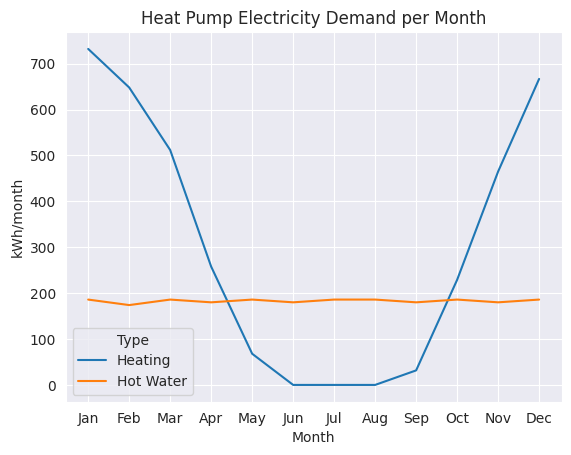

In [3]:
years = 20


def load_data(f):
    df = pl.read_csv(
        f,
        separator=";",
        schema_overrides={"MESS_DATUM": pl.Utf8},
        infer_schema_length=100000,
    )
    return (
        df.rename({c: c.strip() for c in df.columns})
        .rename(
            {
                "MESS_DATUM": "Day",
                "TMK": "DailyMean",
                "TNK": "DailyMin",
                "TXK": "DailyMax",
                "SDK": "SunshineDuration",
            }
        )
        .select(["Day", "DailyMean", "DailyMax", "DailyMin", "SunshineDuration"])
        .with_columns(
            [
                pl.col("Day").str.to_date("%Y%m%d"),
                pl.col("DailyMean").str.strip_chars().cast(pl.Float64),
                pl.col("DailyMax").str.strip_chars().cast(pl.Float64),
                pl.col("DailyMin").str.strip_chars().cast(pl.Float64),
                pl.col("SunshineDuration").str.strip_chars().cast(pl.Float64),
            ]
        )
        .sort(by="Day", nulls_last=True)
        .tail(365 * years)
    )


heating_data = load_data(weather_data_file)

heating_data = (
    heating_data.with_columns(
        pl.col("Day").dt.strftime(r"2000-%m-%d").str.strptime(pl.Date)
    )
    .group_by(pl.col("Day").dt.month().alias("Month"), pl.col("Day").dt.ordinal_day())
    .agg(pl.col("DailyMean").mean())
    .sort(["Day"])
)

# Assuming a COP of 4.0 for heating
heating_data = heating_data.with_columns(
    (
        (heating_threshold - pl.col("DailyMean"))
        / (heating_threshold - design_outdoor_temperature)
        * design_heating_load
    )
    .clip(lower_bound=0, upper_bound=1.5 * design_heating_load)
    .alias("HeatingPower")
).with_columns((pl.col("HeatingPower") / 4.0).alias("HeatingElectricity_kw"))

# Hot water: 12 kWh/day spread over 4 hours (11-14), divided by COP of ~2
hot_water_kwh_daily = hot_water_thermal_heating_demand_per_day_kwh / 2.0
hot_water_kwh_per_hour = hot_water_kwh_daily / 4.0  # In heating window

# Add constant hot water demand to heating_data for plotting
heating_data = heating_data.with_columns(
    pl.lit(hot_water_kwh_daily).alias("HotWaterElectricity_kwh"),
    pl.col("HeatingElectricity_kw").alias("HeatingElectricity_kwh") * 24,
)

# Plot both series - monthly totals
plot_data = (
    heating_data.select(["Month", "HeatingElectricity_kwh", "HotWaterElectricity_kwh"])
    .group_by("Month")
    .agg(
        [
            pl.col("HeatingElectricity_kwh").sum().alias("HeatingElectricity_kwh"),
            pl.col("HotWaterElectricity_kwh").sum().alias("HotWaterElectricity_kwh"),
        ]
    )
    .unpivot(
        index="Month",
        on=["HeatingElectricity_kwh", "HotWaterElectricity_kwh"],
        variable_name="Type",
        value_name="kWh",
    )
    .with_columns(
        pl.col("Type").replace(
            {
                "HeatingElectricity_kwh": "Heating",
                "HotWaterElectricity_kwh": "Hot Water",
            }
        )
    )
)

p = sns.lineplot(data=plot_data.to_pandas(), x="Month", y="kWh", hue="Type")
p.set_title("Heat Pump Electricity Demand per Month")
p.set_xlabel("Month")
p.set_ylabel("kWh/month")
p.set_xticks(range(1, 13))
_ = p.set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)

In [4]:
# Export heating electricity data to CSV
csv_data = (
    heating_data.select(["Month", "HeatingElectricity_kwh", "HotWaterElectricity_kwh"])
    .group_by("Month")
    .agg(
        [
            pl.col("HeatingElectricity_kwh").sum().alias("heating"),
            pl.col("HotWaterElectricity_kwh").sum().alias("water"),
        ]
    )
    .with_columns(
        (pl.col("heating") + pl.col("water")).alias("total"),
    )
    .select(
        [
            pl.col("Month").alias("month"),
            "heating",
            "water",
            "total",
        ]
    )
    .sort("month")
)

# Write to CSV file
csv_data.write_csv("generated-data/simulated-heating-electricity.csv")

print("Data exported to simulated-heating-electricity.csv")
print(csv_data.head())

Data exported to simulated-heating-electricity.csv
shape: (5, 4)
┌───────┬────────────┬───────┬────────────┐
│ month ┆ heating    ┆ water ┆ total      │
│ ---   ┆ ---        ┆ ---   ┆ ---        │
│ i8    ┆ f64        ┆ f64   ┆ f64        │
╞═══════╪════════════╪═══════╪════════════╡
│ 1     ┆ 732.243236 ┆ 186.0 ┆ 918.243236 │
│ 2     ┆ 648.18843  ┆ 174.0 ┆ 822.18843  │
│ 3     ┆ 511.904132 ┆ 186.0 ┆ 697.904132 │
│ 4     ┆ 257.781818 ┆ 180.0 ┆ 437.781818 │
│ 5     ┆ 67.923967  ┆ 186.0 ┆ 253.923967 │
└───────┴────────────┴───────┴────────────┘


Category,Yearly Demand (kWh)
Heating,"3,611"
Hot Water,"2,196"
Household Electricity,"4,224"
Total,"10,030"


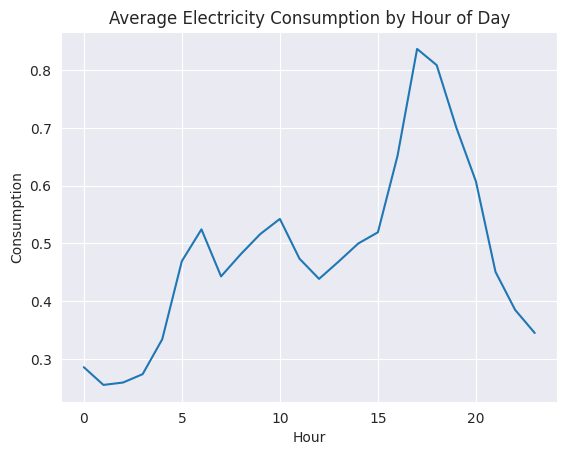

In [5]:
general_consumption = (
    pl.read_csv(electricity_consumption_file)
    .select(["Time", "Verbrauch"])
    .with_columns(
        [
            (pl.col("Verbrauch")).alias("Consumption"),
            (pl.from_epoch("Time", time_unit="ms").alias("DateTime")),
        ]
    )
    .drop("Time")
    .group_by([pl.col("DateTime").dt.hour().alias("Hour")])
    .agg([pl.col("Consumption").mean()])
    .sort(["Hour"])
)

total_consumption = (
    heating_data.select(["Day", "Month", "HeatingElectricity_kw"])
    .join(
        general_consumption,
        how="cross",
    )
    .rename({"Consumption": "Electricity"})
    .with_columns(
        (
            ((pl.col("Hour") >= 11) & (pl.col("Hour") <= 14))
            * pl.lit(hot_water_kwh_per_hour)
        ).alias("HotWater")
    )
    .with_columns(
        (
            pl.col("HeatingElectricity_kw") + pl.col("Electricity") + pl.col("HotWater")
        ).alias("TotalConsumption")
    )
    # Filter out February 28th (day 59) to match production data (non-leap year)
    .filter(pl.col("Day") != 59)
)

# Calculate yearly demand summary
yearly_heating = heating_data["HeatingElectricity_kwh"].sum()
yearly_hot_water = heating_data["HotWaterElectricity_kwh"].sum()
yearly_household = general_consumption["Consumption"].sum() * 365
yearly_total = yearly_heating + yearly_hot_water + yearly_household

demand_summary = pd.DataFrame(
    {
        "Category": ["Heating", "Hot Water", "Household Electricity", "Total"],
        "Yearly Demand (kWh)": [
            yearly_heating,
            yearly_hot_water,
            yearly_household,
            yearly_total,
        ],
    }
)

display(
    demand_summary.style.format({"Yearly Demand (kWh)": "{:,.0f}"}).hide(axis="index")
)

# Plot general electricity consumption by hour of day
p = sns.lineplot(
    data=general_consumption,
    x="Hour",
    y="Consumption",
)
_ = p.set_title("Average Electricity Consumption by Hour of Day")

# Step 2: Simulating Solar Production with Python and PVlib

Next, we simulate the PV system's production using PVlib. We define the modules, inverter, location, and typical weather data to calculate the expected hourly output.

In [6]:
module = pvlib.pvsystem.retrieve_sam(
    path="https://raw.githubusercontent.com/NREL/SAM/develop/deploy/libraries/CEC%20Modules.csv"
)["LG_Electronics_Inc__LG425N2W_V5"]
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS["sapm"][
    "open_rack_glass_glass"
]

latitude, longitude, name, altitude, timezone = (
    50.941299,
    6.958120,
    "Home",
    190,
    "Etc/GMT-1",
)
location = Location(
    latitude,
    longitude,
    name=name,
    altitude=altitude,
    tz=timezone,
)
# Download weather data from PVGIS
weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]
weather.index.name = "utc_time"
weather.to_parquet("generated-data/pvgis_tmy_data.parquet")
# You can cache this:
## weather = pd.read_parquet("generated-data/pvgis_tmy_data.parquet")


# Simulate 1 kW for each orientation to get normalized production profiles
production_per_kw = {}
for orient_name, mount_params in orientations.items():
    # Create a 1 kW system for this orientation
    array = Array(
        mount=FixedMount(**mount_params),
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
        modules_per_string=1,
        strings=1,
    )
    w_peak = module.STC  # ~425W per module
    inverter = {"pdc0": w_peak, "eta_inv": 0.96}
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    mc = ModelChain(system, location, aoi_model="physical", spectral_model="no_loss")
    mc.run_model(weather)
    # Normalize to kWh per kW installed
    production_per_kw[orient_name] = mc.results.ac.p_mp / w_peak  # kWh per kW

print(f"Annual yield per kW installed:")
for orient_name, prod in production_per_kw.items():
    print(f"  {orient_name}: {prod.sum():.0f} kWh/kWp")

/home/christian/code/blog-assets/code/pv-evaluation/.venv/lib/python3.14/site-packages/pvlib/pvsystem.py:2174: UserWarning: Original names contain 505 duplicate(s).
  warnings.warn('Original names contain %d duplicate(s).' % n_duplicates)
/home/christian/code/blog-assets/code/pv-evaluation/.venv/lib/python3.14/site-packages/pvlib/pvsystem.py:2178: UserWarning: Normalized names contain 505 duplicate(s).
  warnings.warn(


Annual yield per kW installed:
  southwest: 1070 kWh/kWp
  facade: 829 kWh/kWp


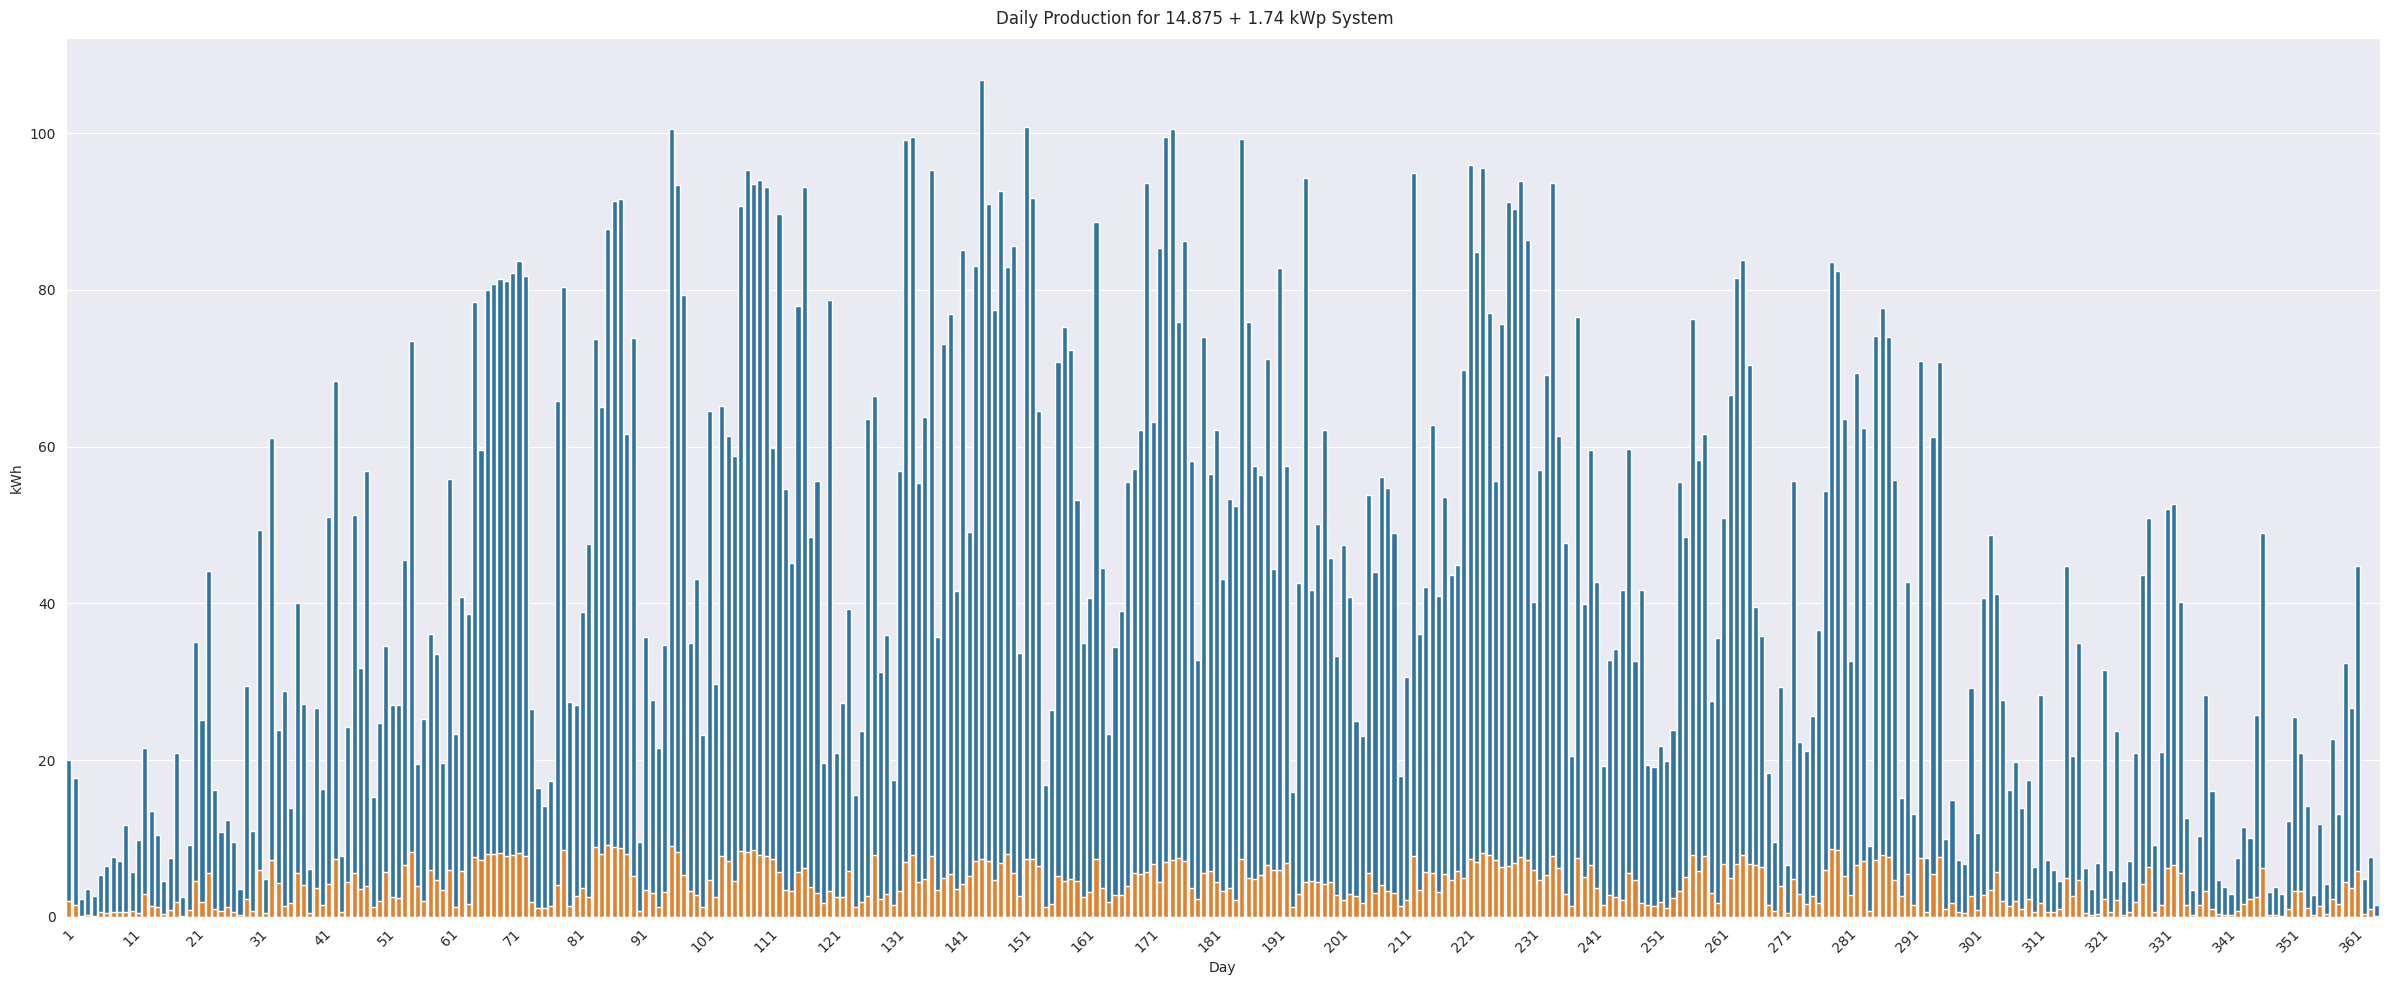

Total for 14.875 + 1.74 kWp per year: 15920.19  +  1442.29 kWh


In [7]:
# Build production DataFrame with per-kW profiles for each orientation
time_index = next(iter(production_per_kw.values())).index

production_profiles = (
    pl.DataFrame(
        {
            "time": time_index.values,
            "southwest_per_kw": production_per_kw["southwest"].values,
            "facade_per_kw": production_per_kw["facade"].values,
        }
    )
    .with_columns(
        pl.col("time")
        .dt.replace_time_zone("UTC")
        .dt.convert_time_zone("CET")
        .alias("DateTime")
    )
    .drop("time")
)

# Example: show daily production for the system
daily = (
    production_profiles.sort("DateTime")
    .with_columns((pl.col("southwest_per_kw") * kwp_southwest).alias("Production SW"))
    .with_columns((pl.col("facade_per_kw") * kwp_facade).alias("Production Facade"))
    .group_by([pl.col("DateTime").dt.ordinal_day().alias("Day")])
    .agg(pl.col("Production SW").sum(), pl.col("Production Facade").sum())
    .sort("Day")
)

plt.figure(figsize=(24, 10))
plt.suptitle(f"Daily Production for {kwp_southwest} + {kwp_facade} kWp System")
sns.barplot(data=daily.to_pandas(), x="Day", y="Production SW")
sns.barplot(data=daily.to_pandas(), x="Day", y="Production Facade")
plt.xticks(np.arange(0, 366, step=10), rotation=45)
plt.ylabel("kWh")
plt.tight_layout()
plt.show()

print(
    f"Total for {kwp_southwest} + {kwp_facade} kWp per year:",
    round(daily["Production SW"].sum(), 2),
    " + ",
    round(daily["Production Facade"].sum(), 2),
    "kWh",
)

# Step 3: Matching Demand and Production

Here we match the simulated production against our demand. We calculate self-consumption (min(demand, production)) and grid usage to understand the system's efficiency.

In [8]:
charging_efficiency = 0.99
discount_rate = 0.05
planning_horizon = 25


@dataclass
class SimResult:
    production: float
    self_consumption: float
    feed_in: float
    total_consumption: float
    self_sufficiency: float
    revenue: float


def simulate_detailed(kw_southwest=0, kw_facade=0, kwh_battery=0):
    """Simulate PV system with given capacities for each orientation."""
    temp = (
        production_profiles.with_columns(
            (
                pl.col("southwest_per_kw") * kw_southwest
                + pl.col("facade_per_kw") * kw_facade
            ).alias("Production"),
        )
        .with_columns(
            [
                pl.col("DateTime").dt.hour().alias("Hour"),
                pl.col("DateTime").dt.month().alias("Month"),
                pl.col("DateTime").dt.ordinal_day().alias("Day"),
            ]
        )
        .join(
            total_consumption.select(["Month", "Day", "Hour", "TotalConsumption"]),
            on=["Month", "Day", "Hour"],
            how="left",
        )
        .sort(["Month", "Day", "Hour"])
        .drop("DateTime", "southwest_per_kw", "facade_per_kw")
        .with_columns(
            balance=pl.col("Production").fill_null(0.0)
            - pl.col("TotalConsumption").fill_null(0.0)
        )
    )

    charging = []
    battery_storage = []
    storage_level = 0
    for balance in temp["balance"]:
        if balance >= 0:
            charge_power = min(
                balance, (kwh_battery - storage_level) / charging_efficiency
            )
            charging.append(charge_power)
            storage_level += charge_power * charging_efficiency
            battery_storage.append(storage_level)
        else:
            charge_power = max(balance, -storage_level)
            charging.append(charge_power * charging_efficiency)
            storage_level += charge_power
            battery_storage.append(storage_level)

    temp = (
        temp.with_columns(
            pl.Series(name="ChargingPower", values=charging, dtype=pl.Float64),
            pl.Series(name="BatteryEnergy", values=battery_storage, dtype=pl.Float64),
        )
        .drop("balance")
        .with_columns(
            (
                pl.col("Production")
                - pl.col("TotalConsumption")
                - pl.col("ChargingPower")
            ).alias("GridBalance")
        )
        .with_columns(
            (-pl.col("GridBalance").clip(upper_bound=0).fill_null(0)).alias("FromGrid"),
            (pl.col("GridBalance").clip(lower_bound=0).fill_null(0)).alias("FeedIn"),
        )
        .with_columns(
            (pl.col("TotalConsumption") - pl.col("FromGrid")).alias("SelfConsumption")
        )
        .with_columns(
            (
                pl.col("FeedIn") * feed_in_price
                + pl.col("SelfConsumption") * electricity_price
            ).alias("Revenue")
        )
    )

    return temp


def simulate(kw_southwest=0, kw_facade=0, kwh_battery=0) -> SimResult:
    temp = simulate_detailed(kw_southwest, kw_facade, kwh_battery).sum()
    return SimResult(
        production=temp["Production"][0],
        self_consumption=temp["SelfConsumption"][0],
        feed_in=temp["FeedIn"][0],
        total_consumption=temp["TotalConsumption"][0],
        self_sufficiency=temp["SelfConsumption"][0] / temp["TotalConsumption"][0],
        revenue=temp["Revenue"][0],
    )

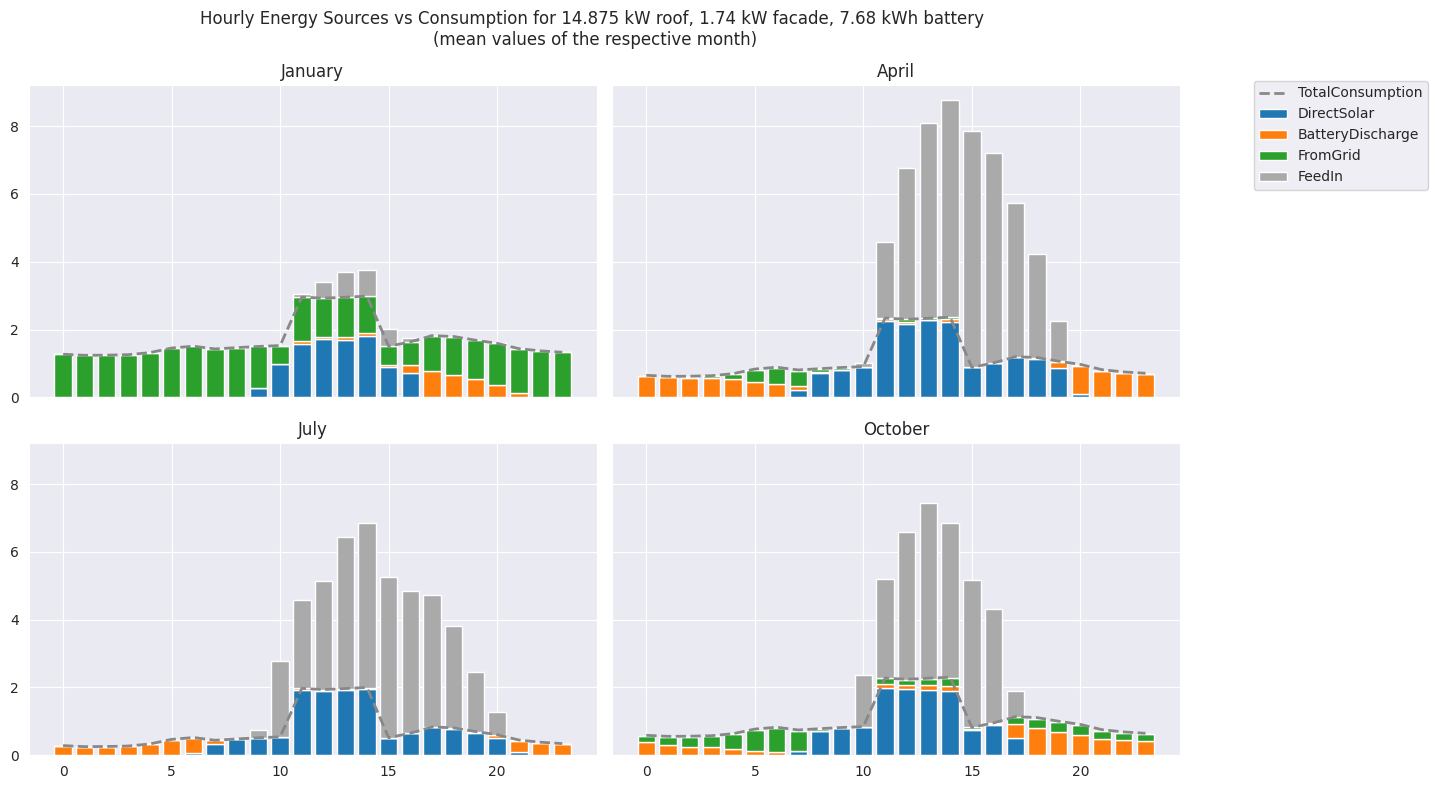

In [9]:
months = [1, 4, 7, 10]
month_name = {"1": "January", "4": "April", "7": "July", "10": "October"}

# Example system for visualization
example_kw_sw = kwp_southwest
example_kw_facade = kwp_facade
example_battery = kwh_battery

# Calculate energy flows for visualization
detailed = simulate_detailed(example_kw_sw, example_kw_facade, example_battery)
hourly = (
    detailed.filter(pl.col("Month").is_in(months))
    .with_columns(
        (-pl.col("ChargingPower").clip(upper_bound=0)).alias("BatteryDischarge"),
    )
    .with_columns(
        (pl.col("SelfConsumption") - pl.col("BatteryDischarge")).alias("DirectSolar")
    )
    .group_by([pl.col("Month"), pl.col("Hour")])
    .agg(
        [
            (pl.col(n).mean()).alias(n)
            for n in [
                "TotalConsumption",
                "DirectSolar",
                "BatteryDischarge",
                "FromGrid",
                "FeedIn",
            ]
        ]
    )
    .sort(["Month", "Hour"])
    .with_columns(pl.col("Month").cast(pl.Utf8).replace(month_name))
)

# Separate data for stacked bars (energy sources) and line (consumption)
flows = ["DirectSolar", "BatteryDischarge", "FromGrid", "FeedIn"]
hourly_sources = hourly.unpivot(index=["Month", "Hour"], on=flows).sort(
    ["Hour", "variable"]
)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
fig.suptitle(
    "Hourly Energy Sources vs Consumption "
    f"for {example_kw_sw} kW roof, {example_kw_facade} kW facade, "
    f"{example_battery} kWh battery \n"
    "(mean values of the respective month)"
)

axes = axes.flatten()

# Get seaborn color palette for consistency
colors = sns.color_palette()
source_colors = {source: colors[i] for i, source in enumerate(flows)}
source_colors["FeedIn"] = "#AAA"

# Create ordered list of month names for proper iteration
ordered_months = [month_name[str(m)] for m in months]

for i, month_name_str in enumerate(ordered_months):
    month_data = hourly.filter(pl.col("Month") == month_name_str).to_pandas()

    # Stacked bars using matplotlib directly
    bottom = np.zeros(len(month_data))
    for source in flows:
        axes[i].bar(
            month_data["Hour"],
            month_data[source],
            bottom=bottom,
            label=source if i == 0 else None,
            color=source_colors[source],
        )
        bottom += month_data[source].values

    # Line for total consumption
    axes[i].plot(
        month_data["Hour"],
        month_data["TotalConsumption"],
        color="#888",
        linewidth=2,
        linestyle="--",
        label="TotalConsumption" if i == 0 else None,
    )
    axes[i].set_title(month_name_str)

# Single legend for the whole figure
fig.legend(loc="upper right", bbox_to_anchor=(1.2, 0.9))
plt.tight_layout()
plt.show()

In [10]:
month_data.round(2)

,Month,Hour,TotalConsumption,DirectSolar,BatteryDischarge,FromGrid,FeedIn
0,October,0,0.59,0.00,0.38,0.19,0.00
1,October,1,0.56,0.00,0.30,0.24,0.00
2,October,2,0.56,0.00,0.24,0.30,0.00
3,October,3,0.58,0.00,0.24,0.32,0.00
4,October,4,0.64,0.00,0.19,0.42,0.00
5,October,5,0.77,-0.00,0.14,0.61,0.00
6,October,6,0.83,-0.00,0.09,0.71,0.00
7,October,7,0.75,0.13,0.01,0.59,0.00
8,October,8,0.78,0.72,0.00,0.07,0.00
9,October,9,0.82,0.81,0.00,0.01,0.00


In [11]:
# Export detailed energy flows to CSV
detailed.write_csv("generated-data/simulated-energy-flows.csv")
print("Detailed energy flows exported to simulated-energy-flows.csv")

Detailed energy flows exported to simulated-energy-flows.csv


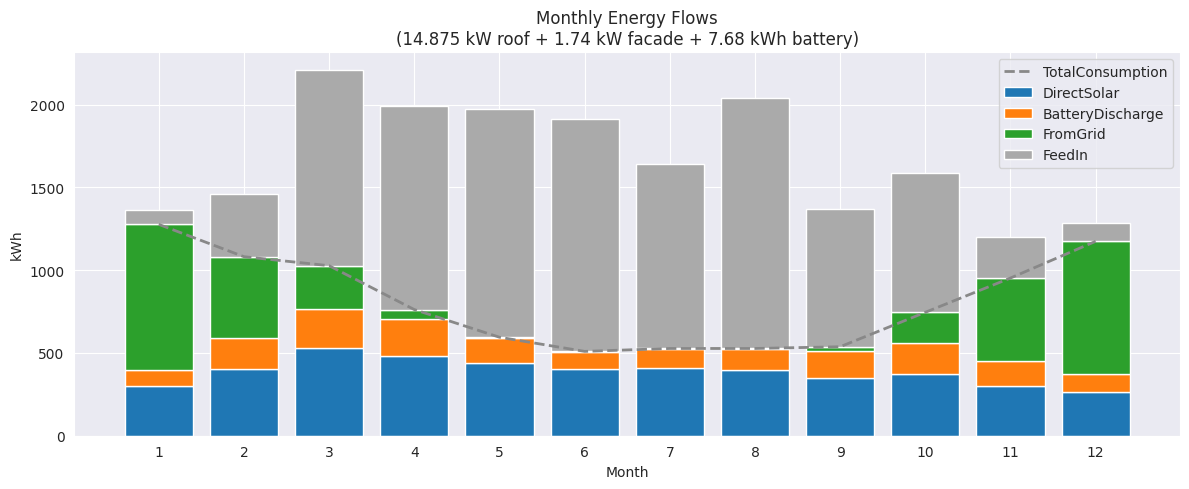

In [12]:
# Monthly totals: Energy flows
monthly = (
    simulate_detailed(example_kw_sw, example_kw_facade, example_battery)
    .with_columns(
        (-pl.col("ChargingPower").clip(upper_bound=0)).alias("BatteryDischarge"),
    )
    .with_columns(
        (pl.col("SelfConsumption") - pl.col("BatteryDischarge")).alias("DirectSolar")
    )
    .group_by(pl.col("Month"))
    .agg(
        [
            pl.col(n).sum()
            for n in [
                "TotalConsumption",
                "DirectSolar",
                "BatteryDischarge",
                "FromGrid",
                "FeedIn",
            ]
        ]
    )
    .sort("Month")
)

flows = ["DirectSolar", "BatteryDischarge", "FromGrid", "FeedIn"]
colors = sns.color_palette()
source_colors = {source: colors[i] for i, source in enumerate(flows)}
source_colors["FeedIn"] = "#AAA"

fig, ax = plt.subplots(figsize=(12, 5))

# Stacked bars for energy flows
bottom = np.zeros(12)
monthly_pd = monthly.to_pandas()
for source in flows:
    ax.bar(
        monthly_pd["Month"],
        monthly_pd[source],
        bottom=bottom,
        label=source,
        color=source_colors[source],
    )
    bottom += monthly_pd[source].values

# Line for total consumption
ax.plot(
    monthly_pd["Month"],
    monthly_pd["TotalConsumption"],
    color="#888",
    linewidth=2,
    linestyle="--",
    label="TotalConsumption",
)

ax.set_title(
    f"Monthly Energy Flows\n"
    f"({example_kw_sw} kW roof + {example_kw_facade} kW facade + {example_battery} kWh battery)"
)
ax.set_xlabel("Month")
ax.set_ylabel("kWh")
ax.set_xticks(range(1, 13))
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Step 4: Investment calculation

We translate the energy flows into Euros using investment costs, electricity prices, and feed-in tariffs. We calculate the Net Present Value (NPV) to assess profitability.

In [13]:
def calculate_investment(kw_peak, kwh_battery):
    return (3000 + 1200 * kw_peak) + (kwh_battery > 0.01) * (1000 + 650 * kwh_battery)


def calculate_kpis(kw_southwest, kw_facade, kwh_battery, investment=None):
    if investment is None:
        investment = calculate_investment(kw_southwest + kw_facade, kwh_battery)
    sr = simulate(kw_southwest, kw_facade, kwh_battery)

    npv = npf.npv(discount_rate, planning_horizon * [sr.revenue])

    return sr, investment, npv, npv - investment


def npv_value(kw_southwest=0, kw_facade=0, kwh_battery=0):
    return calculate_kpis(kw_southwest, kw_facade, kwh_battery)[-1]

# Reality Check: Comparison with Real Offers

Finally, we compare different installer offers against our simulation. We define various scenarios (offers) and compare their economic outcomes side-by-side.

In [14]:
def summarize_scenario(
    kw_southwest=0,
    kw_facade=0,
    kwh_battery=0,
    investment=None,
    name="",
):
    sr = simulate(kw_southwest, kw_facade, kwh_battery)
    electricity_import = sr.total_consumption - sr.self_consumption
    sr.investment = investment or calculate_investment(
        kw_southwest + kw_facade, kwh_battery
    )
    sr.npv = npf.npv(discount_rate, planning_horizon * [sr.revenue]) - sr.investment
    sr.params = dict(
        kw_southwest=kw_southwest,
        kw_facade=kw_facade,
        kwh_battery=kwh_battery,
        investment=sr.investment,
    )
    sr.grid_import = electricity_import

    return sr


offers = [
    dict(
        kw_southwest=30 * 0.43,
        kwh_battery=3.5,
        investment=23661,
        name="Large Power Company",
    ),
    dict(
        kw_southwest=0.43 * 32,
        kwh_battery=9.6,
        investment=22524,
        name="Cheap Startup",
    ),
    dict(
        kw_southwest=12.8,
        kwh_battery=7.8,
        investment=27906 - 1990,
        name="Local Company",
    ),
    dict(
        kw_southwest=14.03,
        kwh_battery=0,
        investment=26000 - 6640,
        name="Recommended Expert (no Battery)",
    ),
    dict(
        kw_southwest=14.03,
        kwh_battery=9.6,
        investment=25240,
        name="Recommended Expert (Battery)",
    ),
]

scenarios = {}
for d in offers:
    scenarios[d["name"]] = summarize_scenario(**d)

# Display results as DataFrame
results_df = pd.DataFrame(
    [
        {
            "Name": name,
            "kW SW": sr.params["kw_southwest"],
            "kW Facade": sr.params["kw_facade"],
            "Battery (kWh)": sr.params["kwh_battery"],
            "Investment (€)": sr.investment,
            "NPV (€)": sr.npv,
            "Production (kWh)": sr.production,
            "Self-Consumption (kWh)": sr.self_consumption,
            "Feed-in (kWh)": sr.feed_in,
            "Grid Import (kWh)": sr.grid_import,
            "Self-Sufficiency (%)": sr.self_sufficiency * 100,
            "Annual Revenue (€)": sr.revenue,
        }
        for name, sr in scenarios.items()
    ]
)

results_df.style.format(
    {
        "kW SW": "{:.1f}",
        "kW Facade": "{:.1f}",
        "Battery (kWh)": "{:.1f}",
        "Investment (€)": "{:,.0f}",
        "NPV (€)": "{:,.0f}",
        "Production (kWh)": "{:,.0f}",
        "Self-Consumption (kWh)": "{:,.0f}",
        "Feed-in (kWh)": "{:,.0f}",
        "Grid Import (kWh)": "{:,.0f}",
        "Self-Sufficiency (%)": "{:.0f}",
        "Annual Revenue (€)": "{:,.2f}",
    }
).hide(axis="index")

Name,kW SW,kW Facade,Battery (kWh),Investment (€),NPV (€),Production (kWh),Self-Consumption (kWh),Feed-in (kWh),Grid Import (kWh),Self-Sufficiency (%),Annual Revenue (€)
Large Power Company,12.9,0.0,3.5,"23,661","12,039","13,806","5,559","7,810","4,158",57,"2,412.40"
Cheap Startup,13.8,0.0,9.6,"22,524","17,503","14,727","6,479","7,785","3,238",67,"2,704.77"
Local Company,12.8,0.0,7.8,"25,916","11,986","13,699","6,215","7,057","3,502",64,"2,561.20"
Recommended Expert (no Battery),14.0,0.0,0.0,"19,360","13,973","15,016","4,494","10,043","5,224",46,"2,252.46"
Recommended Expert (Battery),14.0,0.0,9.6,"25,240","15,210","15,016","6,504","8,039","3,213",67,"2,733.34"


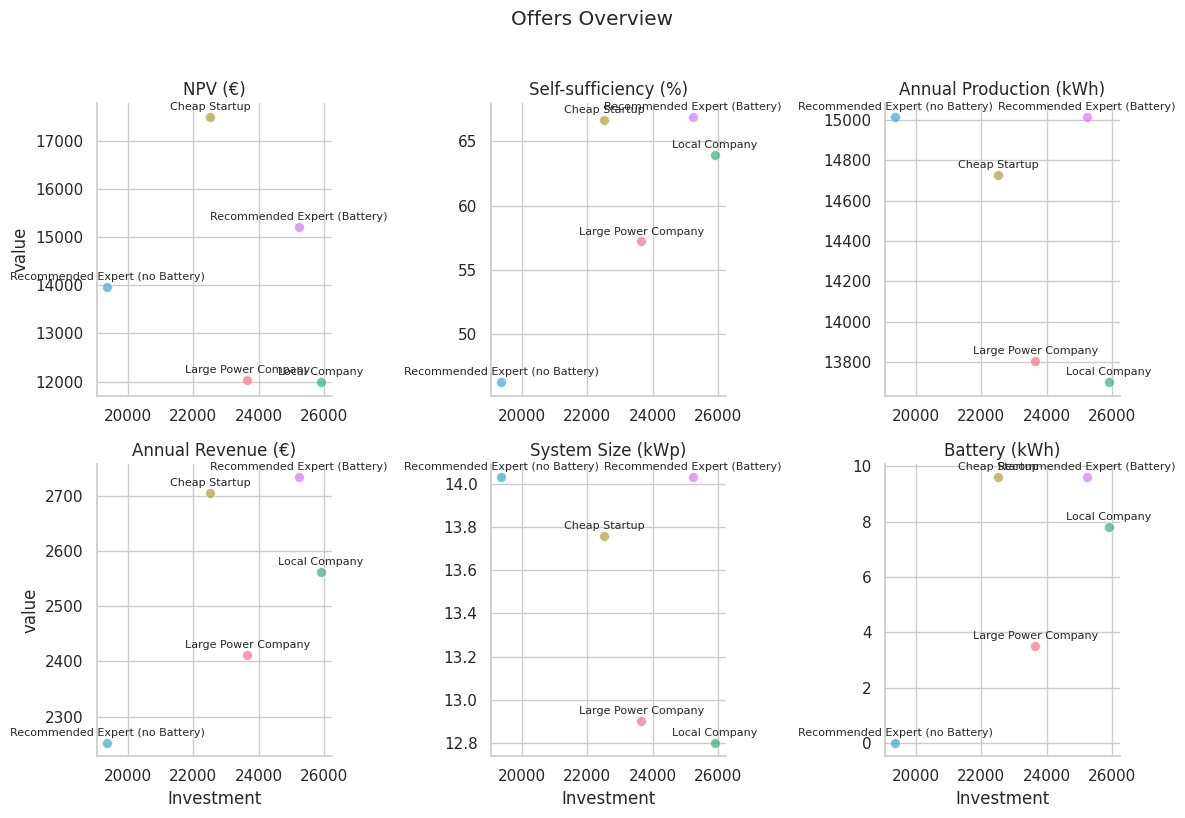

In [15]:
import warnings

df = pd.DataFrame(
    {
        "Name": list(scenarios.keys()),
        "Investment": [sr.investment for sr in scenarios.values()],
        "NPV (€)": [sr.npv for sr in scenarios.values()],
        "Self-sufficiency (%)": [
            sr.self_sufficiency * 100 for sr in scenarios.values()
        ],
        "Annual Production (kWh)": [sr.production for sr in scenarios.values()],
        "Annual Revenue (€)": [sr.revenue for sr in scenarios.values()],
        "System Size (kWp)": [
            sr.params["kw_southwest"] + sr.params["kw_facade"]
            for sr in scenarios.values()
        ],
        "Battery (kWh)": [sr.params["kwh_battery"] for sr in scenarios.values()],
    }
)
melted_df = df.melt(id_vars=["Name", "Investment"])

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    sns.set(style="whitegrid")
    custom_palette = sns.color_palette("husl", n_colors=len(scenarios))

    g = sns.FacetGrid(
        melted_df,
        col="variable",
        col_wrap=3,
        hue="Name",
        sharex=False,
        sharey=False,
        height=4,
        palette=custom_palette,
    )
    g.map(sns.scatterplot, "Investment", "value", marker="o", s=50, alpha=0.7)
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels(x_var="Investment", y_var="Value")

    def annotate_point(*args, **kwargs):
        plt.annotate(
            kwargs["label"],
            (args[0], args[1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
            fontsize=8,
        )

    g.map(annotate_point, "Investment", "value")

    plt.suptitle("Offers Overview", y=1.02)
    plt.tight_layout()
    plt.show()